[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part2/blob/main/MOOC_Notebooks/Notebook07_CNNs.ipynb)

# Notebook 07: Convolutional Neural Networks 

Authors: Randy J. Chase, David R. Harrison, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks and Deep Learning](https://arxiv.org/abs/2211.00147)<br>
Original Github: [WAF_ML_Tutorial_Part2](https://github.com/ai2es/WAF_ML_Tutorial_Part2)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Lackmann, G. M., & McGovern, A. (2023). A Machine Learning Tutorial for Operational Meteorology. Part II: Neural Networks and Deep Learning, 	arXiv:2211.00147.

### Primary Goal:

Build and train a convolutional neural network 

#### Background

Now that we have throughly discussed what a convolution is, here we will dive into training a convolutional neural network on the ```sub-sevir``` dataset. 

#### Step 0

As with all of our notebooks, we will first install packages and grab data

Note: downloading the data can take up to 15-20 mins depending on the server speed. Please be patient

In [ ]:
#@title Install and unpack files [this will take some time]

print('installing dependancies')
!pip -q install zenodo-get
!pip -q install zarr 
print('grabbing sub-sevir')
!zenodo_get 7011372
print('unpacking sub-sevir')
!tar -xf sub-sevir.tar.gz
!tar -xf sub-sevir/sub-sevir-train.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-val.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-test.tar.gz -C sub-sevir/
print('grabbing the Github repo')
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part2.git
print('done')

#### Step 1: Imports

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#### Step 2: Load in ```sub-sevir```

You'll need to update the following paths to the location where you downloaded the data from Notebook 1. 

In [2]:
ds_train = xr.open_dataset('sub-sevir/sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir/sub-sevir-val.zarr',engine='zarr')

By design the ```sub-sevir``` data are 'machine learning ready'. This means that the normalization has already been done (i.e., the features have mean 0 and std 1) and the data are already split into the required groups (train/val/test). So in terms of preparing the data, we only have to pick what features we want to use for training and decide what the learning task is (i.e., classification/regression). 

#### Step 3: Convert data into tensors 

Before training a machine learning model, we must first convert the data from xarray to tf.datasets. The first task in this tutorial will be a classification (i.e., "Does this image contain a thunderstorm?"), so we will choose the ```label_1d_class''' variable as our truth data. 

In [3]:
ds_train

<xarray.Dataset>
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object ...
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2018-08-25T00:15:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

In [4]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_1d_class.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_1d_class.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 32
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

2022-12-13 12:41:55.215581: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Step 4: Reminder of ```tf.data.Datasets```

The concept of a tensorflow dataset might be new for many readers. Therefore, we will take a moment to describe them again here. 

To help the machine learning converge on a solution in a timely matter, we first estimate how to adjust the weights of the model (i.e., the gradient of the model with respect to the error) on some *random subset* of the total training data (i.e., batch). This is accomplished by shuffling the data every epoch and randomly selecting batches. Tensorflow's Dataset class makes this easy by providing pre-defined ```.shuffle()``` and ```.batch()``` methods. The code above implements both of those methods. 


Frequently asked question: "How do I look at the data stored in a ```tf.data.Dataset```?"

If you print out this variable, it doesn't show you much: 

In [5]:
ds_train

<BatchDataset shapes: ((None, 48, 48, 4), (None,)), types: (tf.float32, tf.int8)>

Here, the output tells us that the shape of the data is ```(None, 48,48,4)```. The ```None``` might be confusing, but this represents the batch size which we manually set to 32 above. The other dimensions are the 48 x-pixels, 48 y-pixels and 4 variables (i.e., channels). Similarly, our truth dataset is of the shape ```None``` and contains values of 1 or 0 depending on if the image has lightning in it. 

To get a batch, we can *iterate* over this dataset. The following code will loop once to get the first batch. 

In [6]:
for batch in ds_train:
    break 

In [7]:
batch

(<tf.Tensor: shape=(32, 48, 48, 4), dtype=float32, numpy=
 array([[[[ 6.93003118e-01,  1.29607499e+00, -2.06395701e-01,
           -4.76107270e-01],
          [ 6.66918874e-01,  1.24724758e+00, -2.06395701e-01,
           -4.95039463e-01],
          [ 6.16433203e-01,  1.26972377e+00, -2.06395701e-01,
           -5.44263005e-01],
          ...,
          [-5.85124910e-01, -6.91892385e-01, -2.06395701e-01,
            1.07727516e+00],
          [-4.26936805e-01, -4.88832980e-01, -2.06395701e-01,
            8.44883144e-01],
          [ 1.21673852e-01,  5.98542571e-01, -2.06395701e-01,
           -6.10200316e-02]],
 
         [[ 6.57663167e-01,  1.13254237e+00, -2.06395701e-01,
           -2.03011125e-01],
          [ 6.30737484e-01,  1.19415772e+00, -2.06395701e-01,
           -5.18704653e-01],
          [ 6.10543251e-01,  1.26739872e+00, -2.06395701e-01,
           -5.26750803e-01],
          ...,
          [-7.13863552e-01, -8.10085356e-01, -2.06395701e-01,
            1.12697208e+00],

Now you can see that a batch is collection of 32 *tuples* made up of the images and the labels. Nice right? We can visualize just one example to show the whole proccess:

<tf.Tensor: shape=(), dtype=int8, numpy=0>

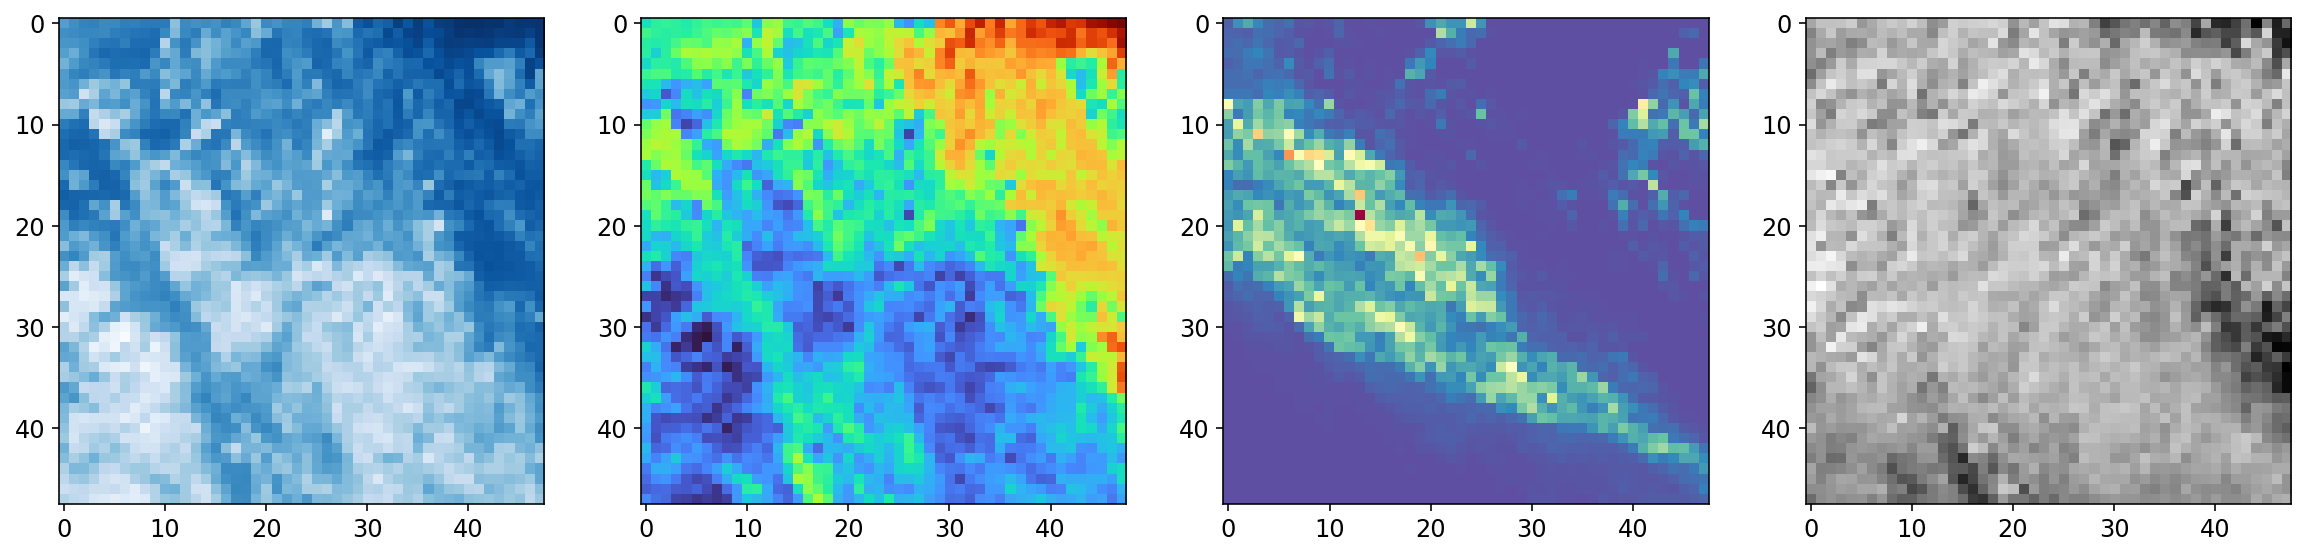

In [8]:
#get the features for example 12 in this batch 
one_example_features = batch[0][12]
#get the label for that same example 
one_example_label = batch[1][12]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label

there ya go! Now you have a way to dig into the data when they are in this tf.data.Dataset form. 

Just know that if you iterate this dataset again, you will get a new (random) example for the same index... 

<tf.Tensor: shape=(), dtype=int8, numpy=0>

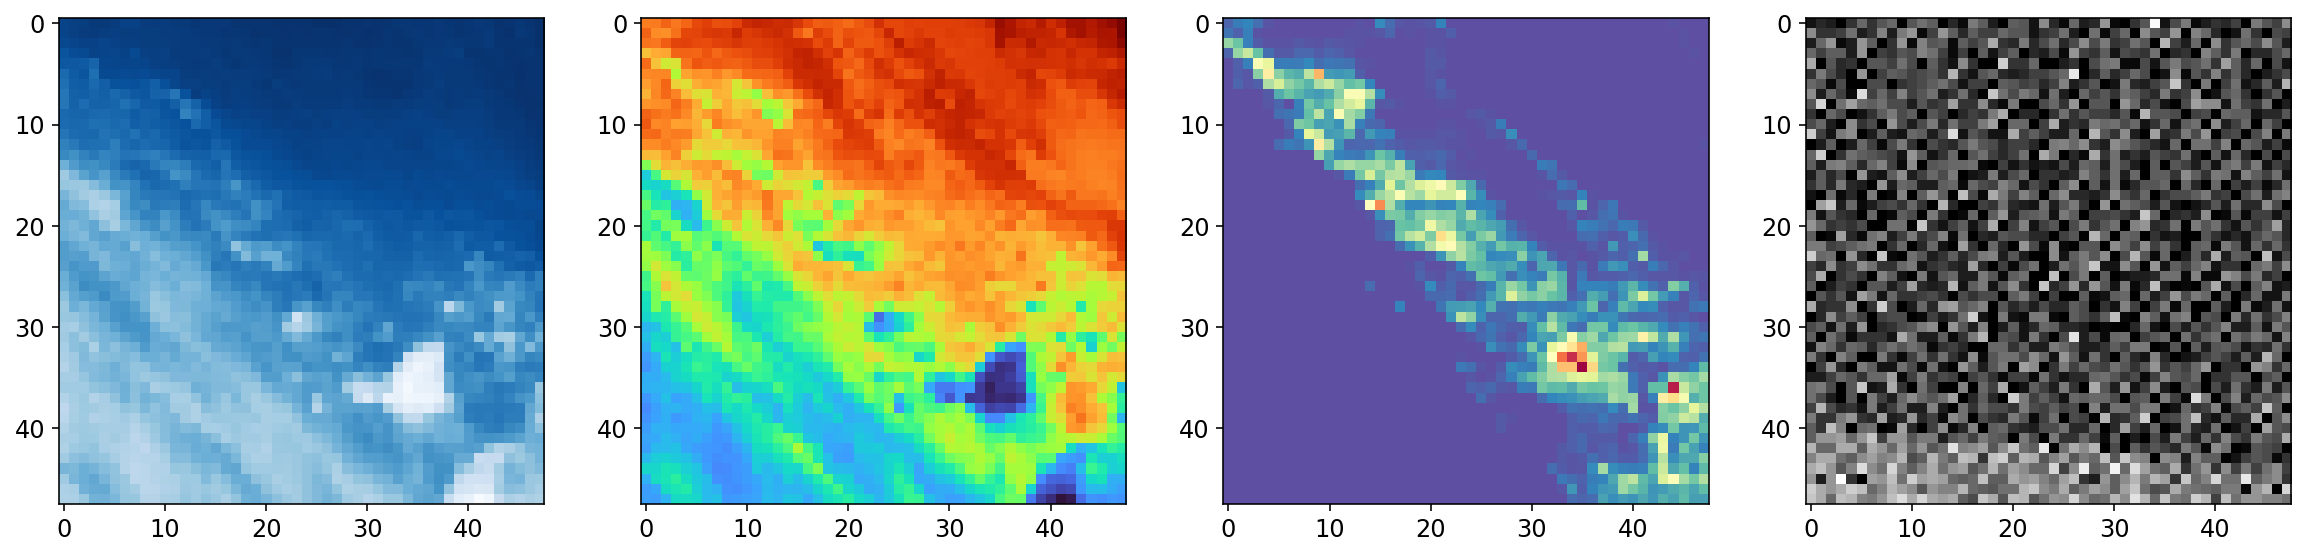

In [9]:
for batch in ds_train:
    break 
    
#get the features for example 12 in this batch 
one_example_features = batch[0][12]
#get the label for that same example 
one_example_label = batch[1][12]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label

#### Step 5: Build CNN model

We can use the same sequential model demonstrated in Notebook 5 (ANNs) to build our CNN. 

Let's start simple with the following: 

1) A single convolutional layer with 3x3 filters and 1 output map. 


In [10]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(1,kernel_size=3,activation='relu',input_shape=(ds_train.element_spec[0].shape[1:]),),
    
        #need to flatten/ravel the 2d image into a 1d vector 
        tf.keras.layers.Flatten(),
        
        #output layer (apply sigmoid because binary classification
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 1)         37        
                                                                 
 flatten (Flatten)           (None, 2116)              0         
                                                                 
 dense (Dense)               (None, 1)                 2117      
                                                                 
Total params: 2,154
Trainable params: 2,154
Non-trainable params: 0
_________________________________________________________________


#### Step 6: Run some data through

It can be useful to run your data through the untrained model to see how it performs with completely random weights. 

(0.0, 1.0)

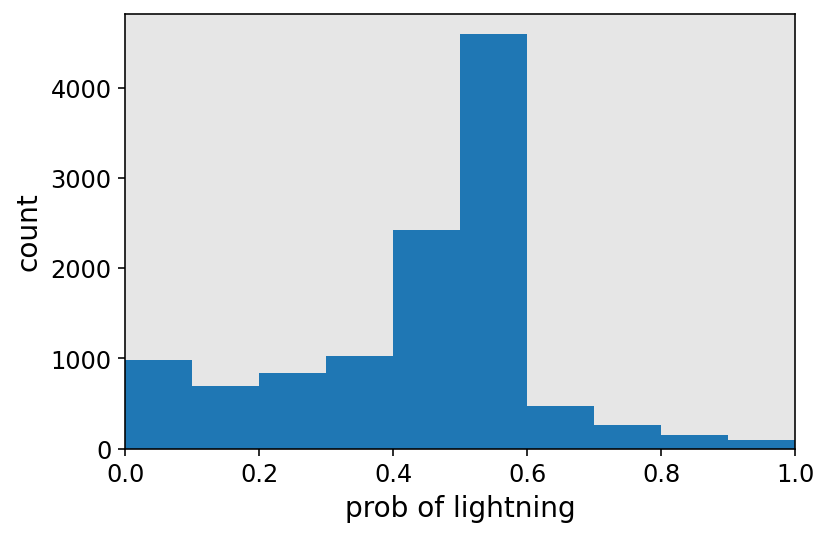

In [11]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

As expected, the model is producing predictions [0,1], and the predictions generally fall in the middle of the probability distribution. 

Let's take a look at the performance diagram. To do that, we first need convert the truth label from a ```tf.data.Dataset``` to a vector. 

In [12]:
y_v = np.array([])
for _,y in ds_val:
    y_v = np.append(y_v,y)


In [13]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

posx and posy should be finite values
posx and posy should be finite values


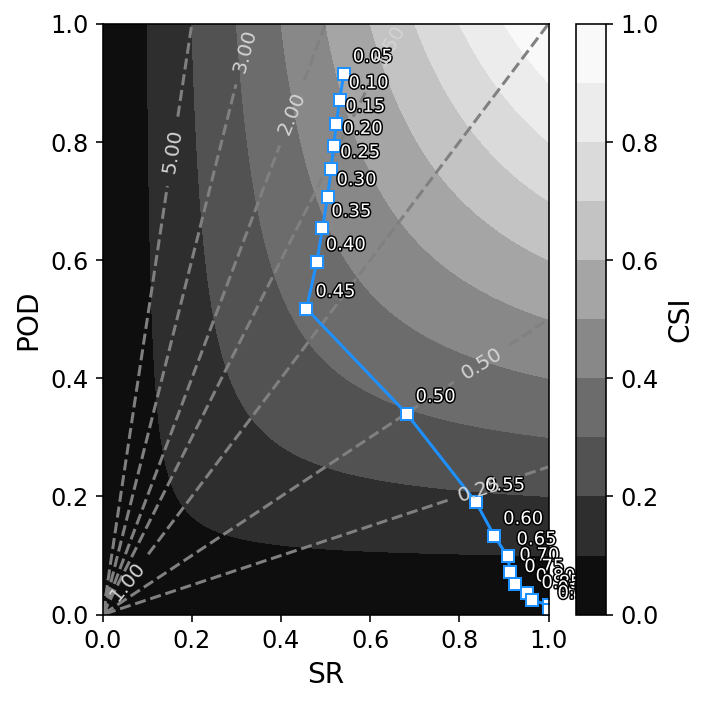

In [14]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

There are some funky things to note with this performance diagram. It might seem like random weights work well, but remember that the validation dataset is roughtly balanced (no lightning: 44%; lightning: 56%), so even a random guess can demonstrate decent performance. Also notice how the curve appears disjoint, almost as if there is an inflection point for the probability value of 0.45.  This is not a desirable behavior for performance plotted on this diagram. 

If you want to view the convolution filters, you can see them by doing the following: 

In [15]:
#grab layer 1 weights, which are the convolution filters. 
filters = model.weights[0]

filters.shape

TensorShape([3, 3, 4, 1])

Let's take a look at each of the filters. Notice we have one for each feature (dims are [x,y,variable,output]).

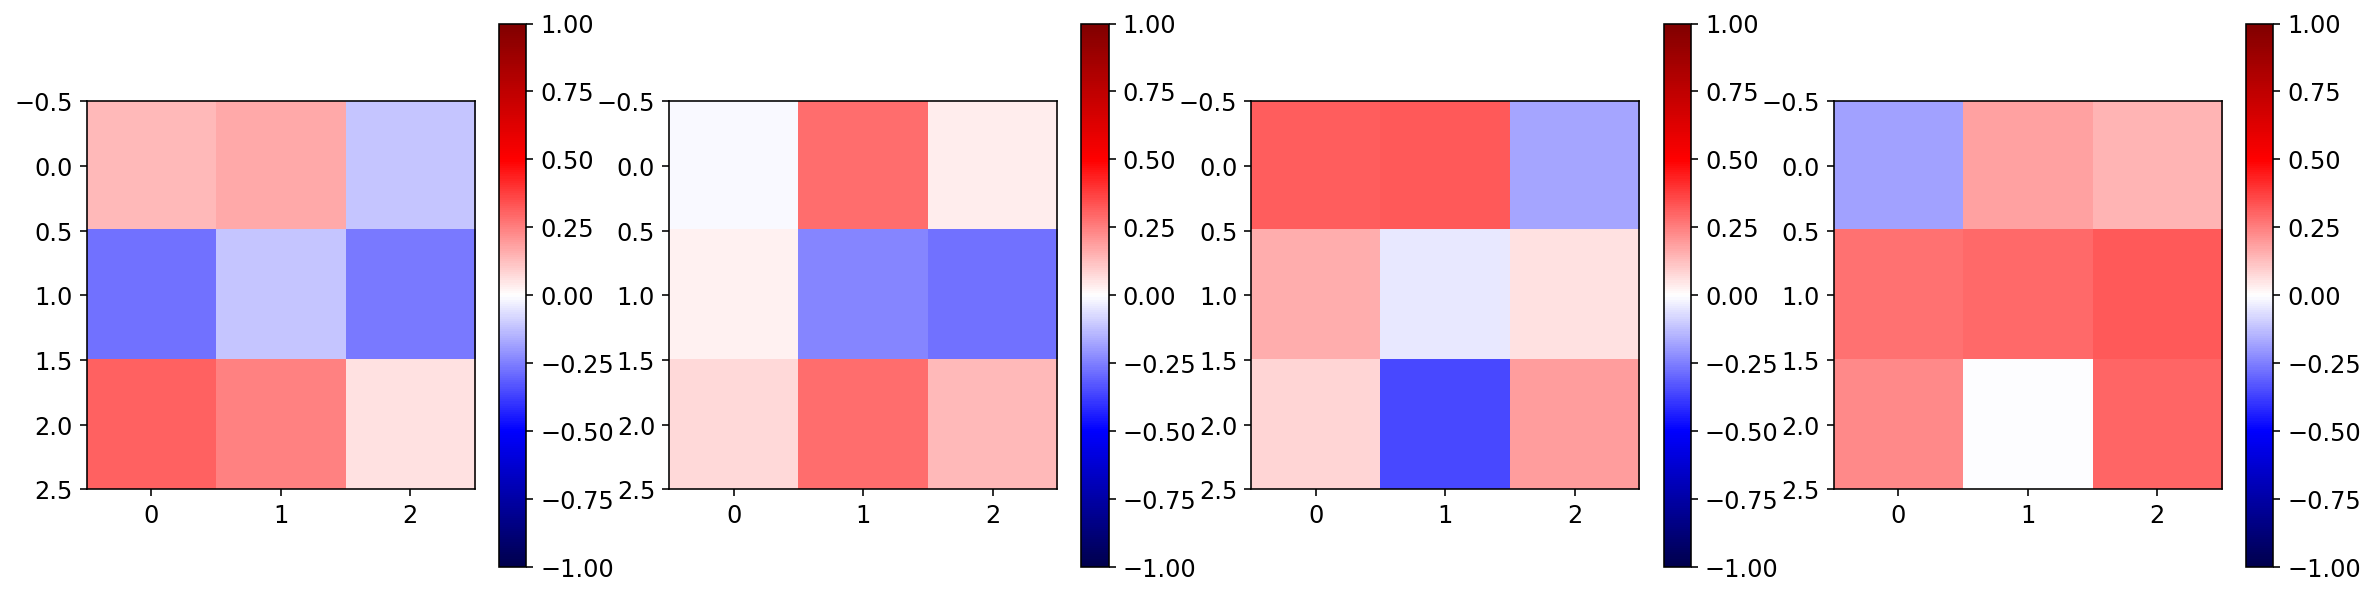

In [16]:
fig,axes = plt.subplots(1,4,figsize=(20,5))

for i in np.arange(0,4):
    pm = axes[i].imshow(filters[:,:,i,0],vmin=-1,vmax=1,cmap='seismic')
    plt.colorbar(pm,ax=axes[i])
    

This really isn't very informative, but you can see how the values are approximately equally distributed around 0. This distribution is provided in the initialzation step when first creating the model. 

Maybe looking at the output of the convolutional layer will help? First, let's print out the layer names.  Then, Tensorflow/keras lets us output specific layers by doing the following:


In [17]:
for l,layer in enumerate(model.layers):
    print(l,layer.name)

0 conv2d
1 flatten
2 dense


For our simple model, the convolution layer name is ```conv2d```.  Here, we will use that *key* to build a new model that outputs only that layer.

In [18]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(ds_val)

#grab a batch to look at 
for batch in ds_val:
    break 

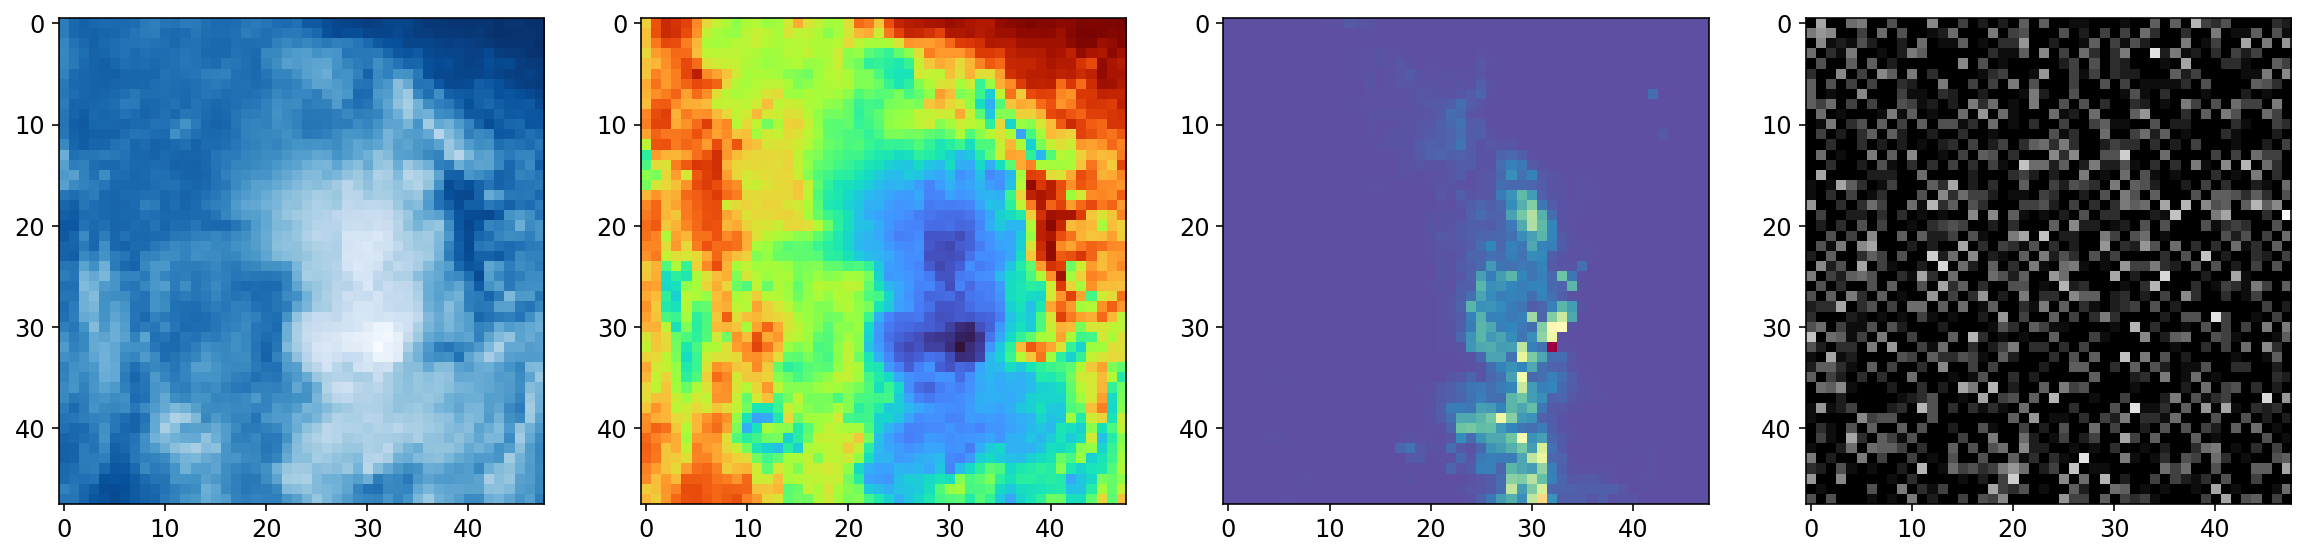

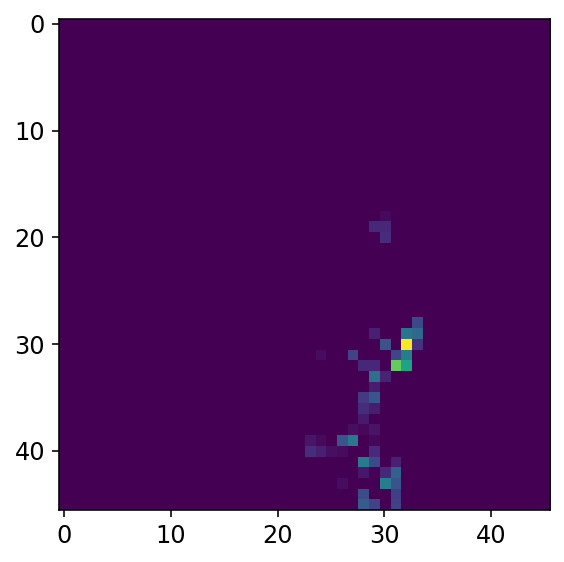

In [19]:
#get the features for example 12 in this batch 
one_example_features = batch[0][0]
#get the label for that same example 
one_example_label = batch[1][0]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label


plt.figure(figsize=(4.4,5))
plt.imshow(convolved_images[0])

Notice that even for completely random filter weights (i.e., no training), the CNN still highlights the region where a storm is. This is probably why the performance diagram looks decent.

#### Step 7: Train the model for 10 epochs

Okay, enough digging in the weeds. Let's compile and train the model!

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

history = model.fit(ds_train,validation_data=ds_val,epochs=20)

Epoch 1/20
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4264 - val_loss: 0.3262
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3031 - val_loss: 0.3102
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2925 - val_loss: 0.3083
Epoch 4/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2900 - val_loss: 0.2959
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2896 - val_loss: 0.3050
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2877 - val_loss: 0.2943
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2862 - val_loss: 0.3066
Epoch 8/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2864 - val_loss: 0.3153
Epoch 9/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2873 - val_loss: 0.2956
Epoch 10/20
1875/1875 [==============================] - 10s 5ms/step - l

Depeneding on your computer, this might take some time to run.

#### Step 8: Check for overfitting

As always, we should probably check to see if the model is overfitting. To do this, let's plot the loss curves for both the training data and the validation data:

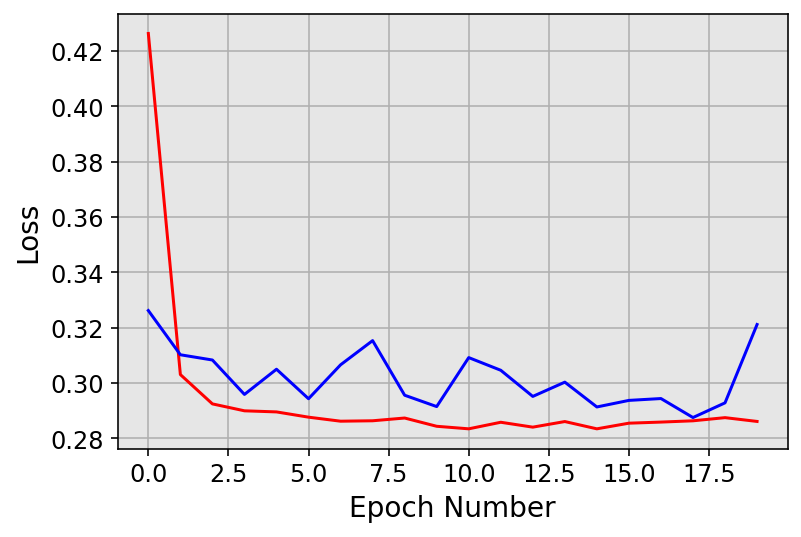

In [21]:
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

Take a moment and consider if overfitting has occured. Remember, you are looking to see if the red line continues to decrease while the blue line increases. 

In this example, I would say that the model has probably begun to overfit.  Specifically, the validation loss begins to consistently increase around epoch 17. Let's check on the overall performance anyway.

#### Step 9: Check performance

To check the perfomance, we can reuse the same code from earlier in this tutorial:

(0.0, 1.0)

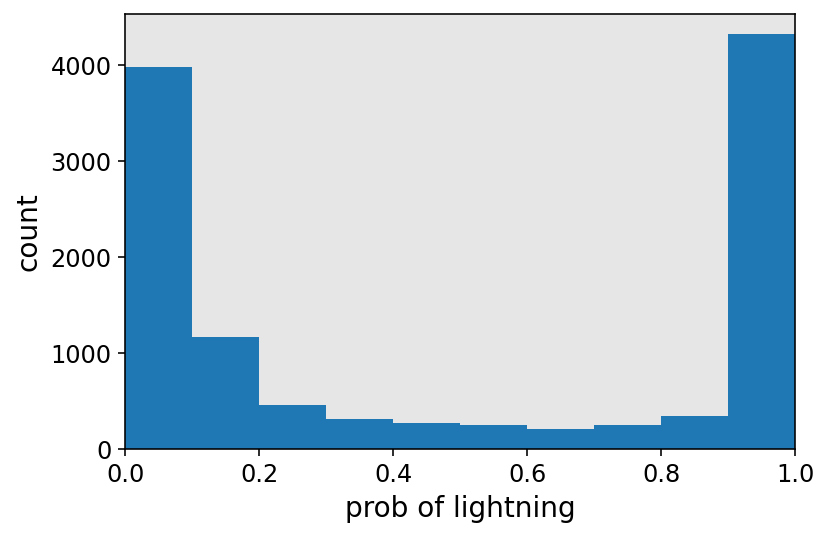

In [22]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

Here we can see there is a good grouping of examples where the model predicts class probabilities near 0 and 1, and then there are relatively few cases where the output of the model is more in the middle of the distribution (i.e., more uncertain). 

Let's make the performance diagram again:

In [23]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

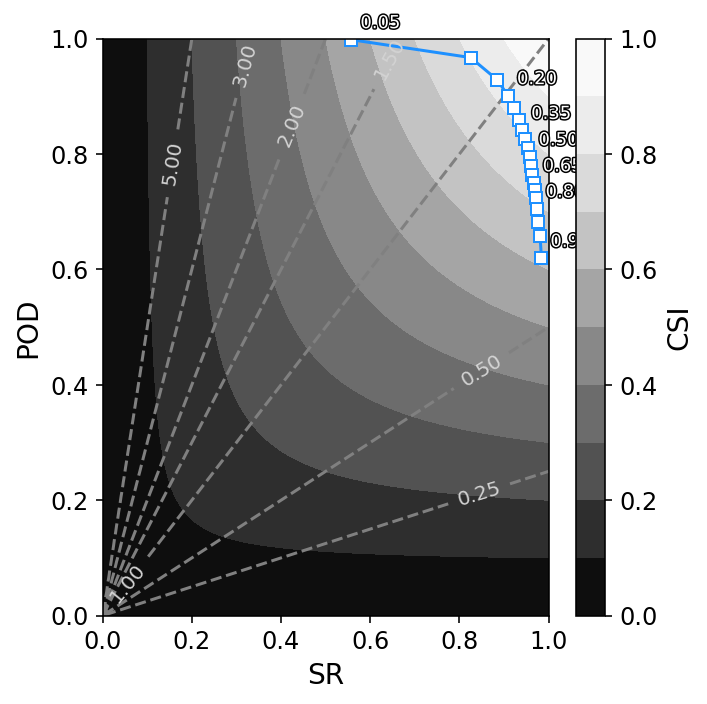

In [24]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    if np.mod(i,3)==0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

We get much better results this time.  The model has a maximum CSI value of about 0.81 when using a class probability of 0.2 as the deterministic threshold.

Can we see what filter it learned?

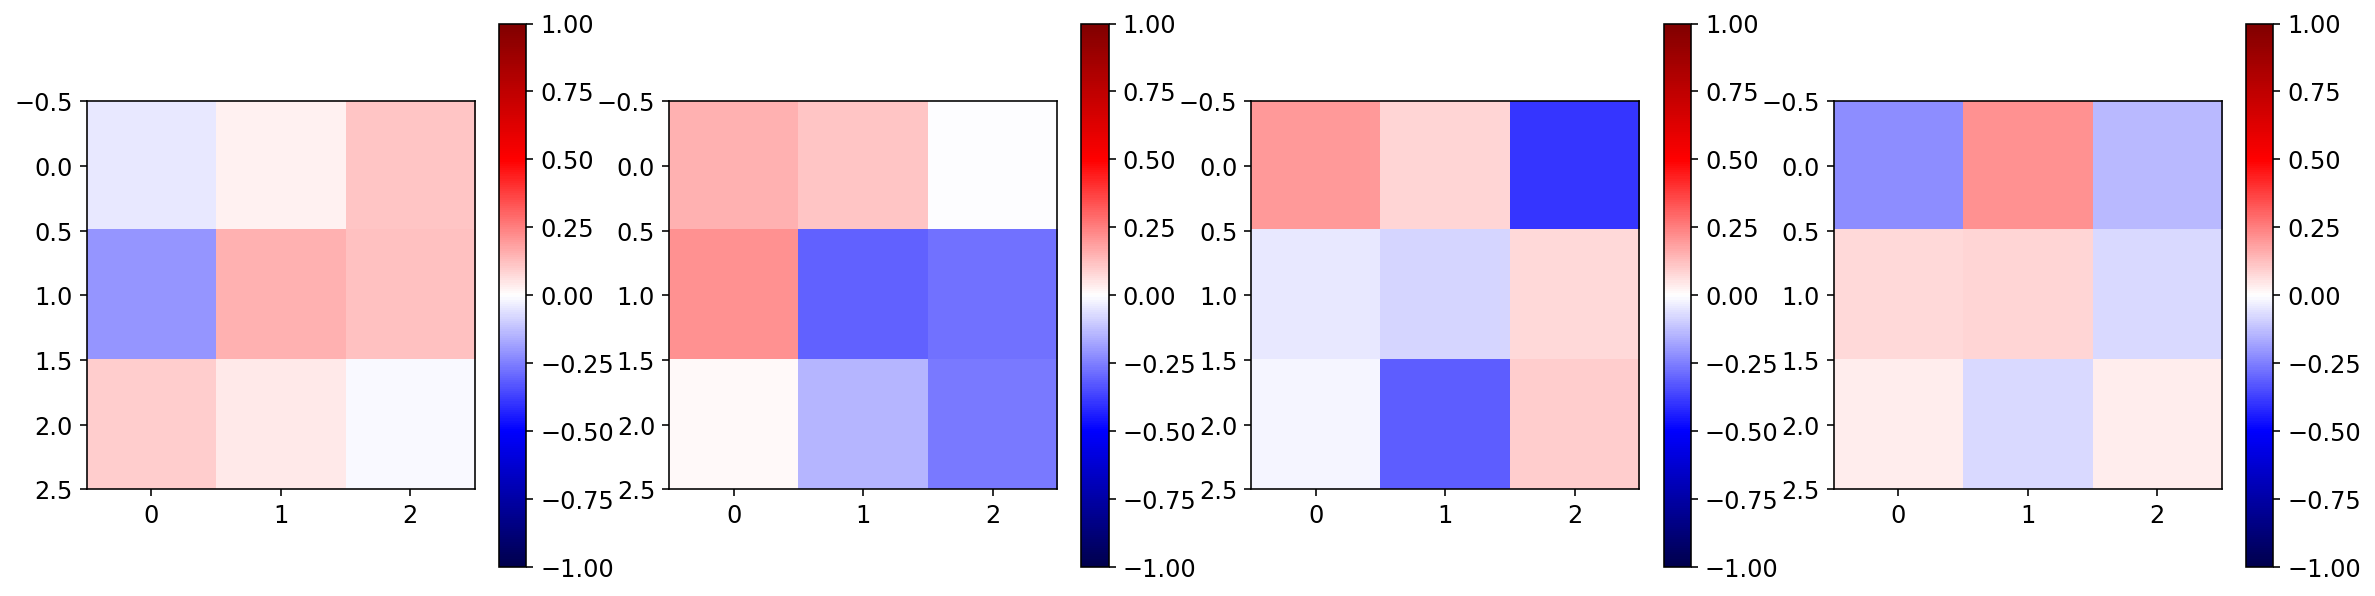

In [25]:
#grab layer 1 weights, which are the convolution filters. 
filters = model.weights[0]

filters.shape

fig,axes = plt.subplots(1,4,figsize=(20,5))

for i in np.arange(0,4):
    pm = axes[i].imshow(filters[:,:,i,0],vmin=-1,vmax=1,cmap='seismic')
    plt.colorbar(pm,ax=axes[i])

As before, it doesn't seem very useful to look at the kernels themselves, so let's look at the output of the convolutional layer instead.

In [26]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(ds_val)

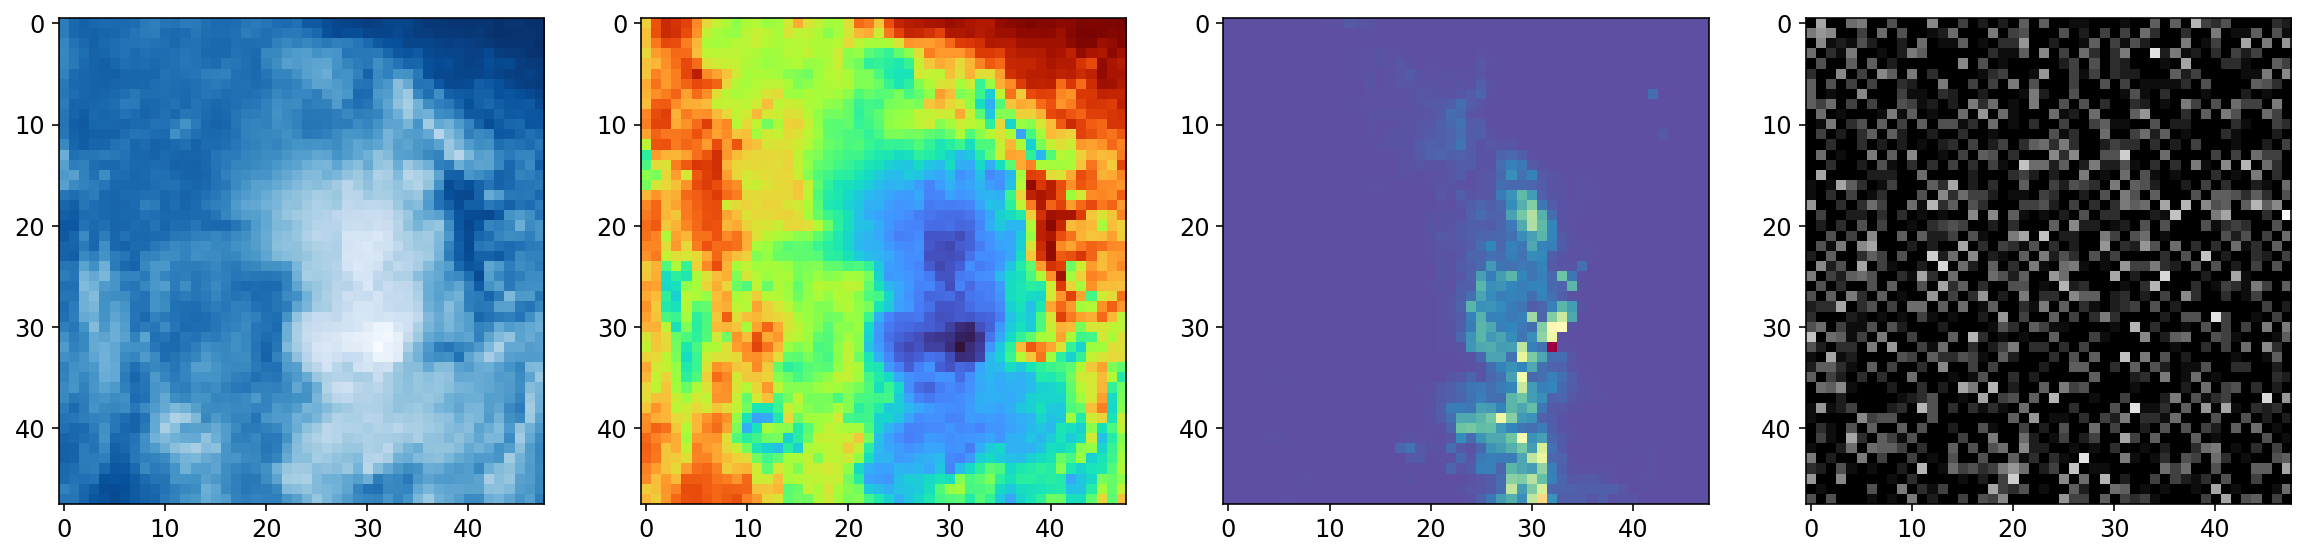

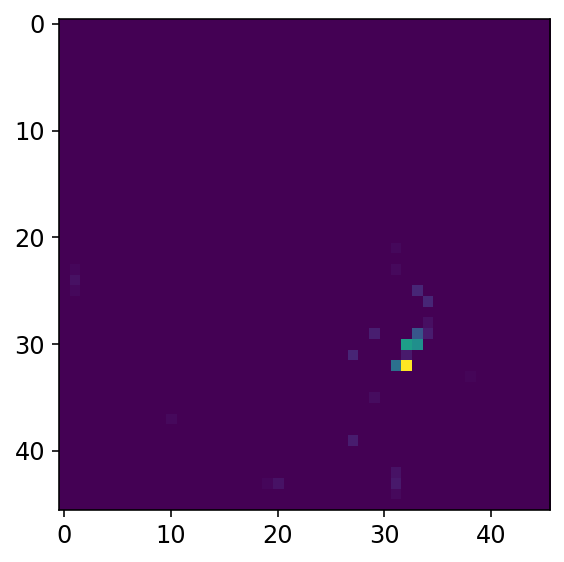

In [27]:
#get the features for example 12 in this batch 
one_example_features = batch[0][0]
#get the label for that same example 
one_example_label = batch[1][0]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label


plt.figure(figsize=(4.4,5))
plt.imshow(convolved_images[0])

The result here is actually quite similar to the untrained model, although the convolved data does look a bit more 'focused' in on the area where there are cold cloud tops and high radar values. 

This is probably not a very satisfying explanation for trained models behavior. Thus, later on in this tutorial series there is a notebook discussing more quantitative methods for explaining the CNN.

#### Step 10: Save the model

Since this model performs pretty well, let's go ahead and save it. 

In [28]:
model.save('/content/WAF_ML_Tutorial_Part2/datasets/models/neural_nets_from_notebooks/MyFirstCNN.h5')

#### Step 11: Add an ANN 

Typically CNNs have their convolution and maxpool layers, but then after some number of them, the covolutional data is fed through an ANN. This task seems to do well with just a single convolutional layer, but for the sake of completeness, let's add an ANN. 

In [29]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(1,kernel_size=3,activation='relu',input_shape=(ds_train.element_spec[0].shape[1:]),),
    
        #need to flatten/ravel the 2d image into a 1d vector 
        tf.keras.layers.Flatten(),
    
        #add two dense layers (which is the same as an ANN)
        tf.keras.layers.Dense(16,activation='relu'), 
        tf.keras.layers.Dense(32,activation='relu'),
        
        #output layer (apply sigmoid because binary classification
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 46, 46, 1)         37        
                                                                 
 flatten_1 (Flatten)         (None, 2116)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                33872     
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,486
Trainable params: 34,486
Non-trainable params: 0
_________________________________________________________________


Now you can see there are a few more trainable parameters (i.e., weights).

#### Step 12: Train the new model 

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

history = model.fit(ds_train,validation_data=ds_val,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.3105 - val_loss: 0.3002
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2327 - val_loss: 0.2937
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2022 - val_loss: 0.3144
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1783 - val_loss: 0.3395
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1581 - val_loss: 0.3602
Epoch 6/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.1421 - val_loss: 0.3840
Epoch 7/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.1274 - val_loss: 0.4285
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1162 - val_loss: 0.4646
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1083 - val_loss: 0.4992
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

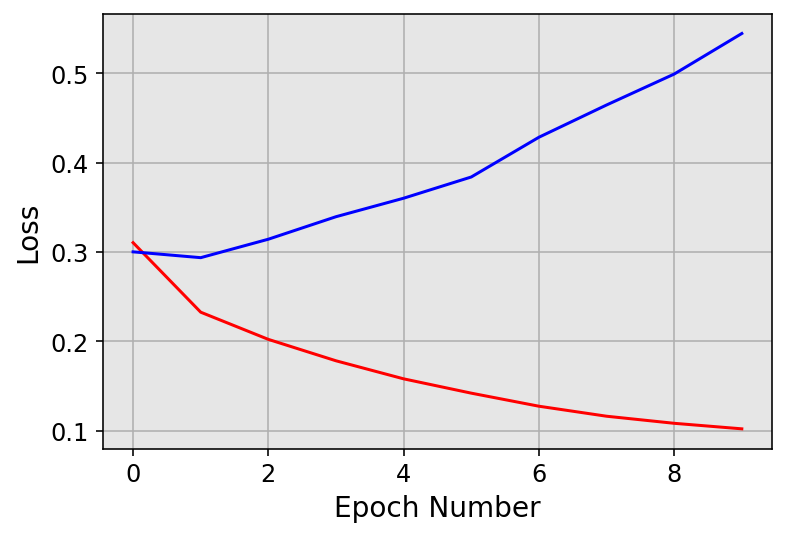

In [31]:
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

This is a clear overfitting signiture. It would seem that adding these extra parameters did not help our model. 

#### Step 13: Add regularization (fix overfitting)

This is a good time to introduce some regularization tips that can help avoid overfitting. First, let's try adding dropout. This is where neurons are randomly turned on/off to prevent the neural network from memorizing examples (i.e., a specific pathway for a specific example in your training dataset).

In [32]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(1,kernel_size=3,activation='relu',input_shape=(ds_train.element_spec[0].shape[1:]),),
    
        #need to flatten/ravel the 2d image into a 1d vector 
        tf.keras.layers.Flatten(),
    
        #add dense layer 
        tf.keras.layers.Dense(16,activation='relu'),
        #add a layer of dropout where 1/3 of the neurons are randomly turned off 
        tf.keras.layers.Dropout(0.33),
        #add another dense layer 
        tf.keras.layers.Dense(32,activation='relu'),
        #add another dropout layer 
        tf.keras.layers.Dropout(0.33),
        
        #output layer (apply sigmoid because binary classification
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 1)         37        
                                                                 
 flatten_2 (Flatten)         (None, 2116)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                33872     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

history = model.fit(ds_train,validation_data=ds_val,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.3639 - val_loss: 0.2955
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2733 - val_loss: 0.2847
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2586 - val_loss: 0.2824
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2596 - val_loss: 0.2588
Epoch 5/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2563 - val_loss: 0.2641
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2558 - val_loss: 0.2639
Epoch 7/10
1875/1875 [==============================] - 12s 5ms/step - loss: 0.2557 - val_loss: 0.2533
Epoch 8/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2556 - val_loss: 0.2577
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2582 - val_loss: 0.2616
Epoch 10/10
1875/1875 [==============================] - 11s 5ms/step - l

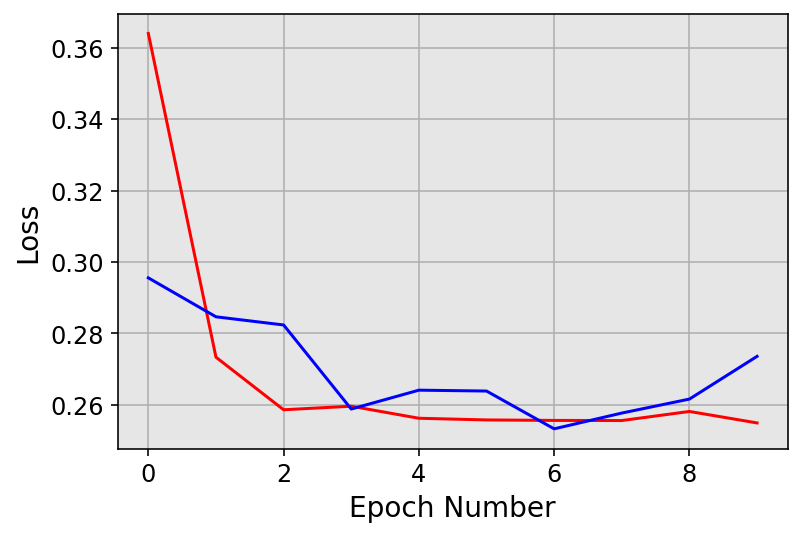

In [34]:
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

As you can see here, the dropout seems to have prevented much of the overfitting signal. However, there may still be some slight overfitting here from about epoch 6 on. 

#### Step 14: Check performance again 

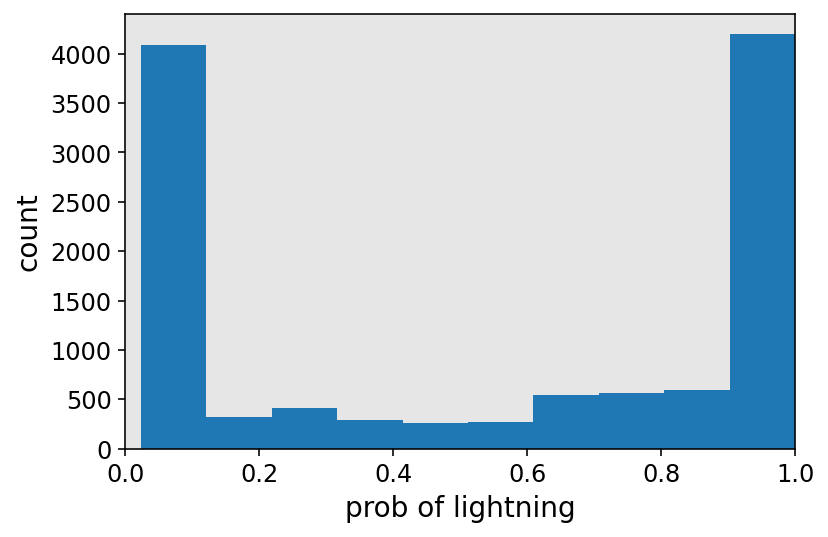

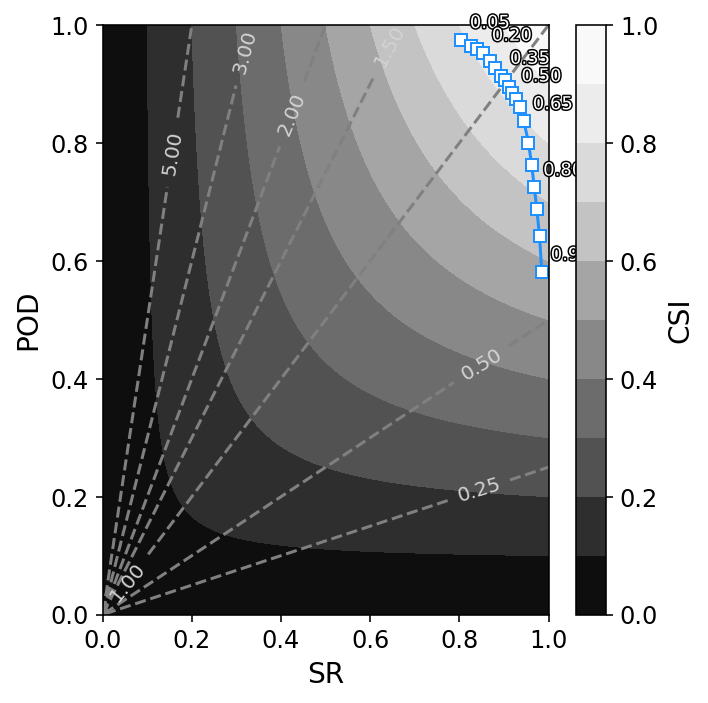

In [35]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    if np.mod(i,3)==0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

There ya go! You have trained a more typical CNN structure. 

The next notebook will dive into using U-nets, which will not only tell us if there is lightnign in the image but also where that lightning is. 